# Kinetic Energy Mean-Transient Decomposition

Decomposing the kinetic energy into time-mean and transient components.

## Theory

For a hydrostatic ocean model, like MOM5, the relevant kinetic energy per unit mass is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ {\rm TKE} = \left< {\rm KE} \right > {\stackrel{\rm{def}}{=}} \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right)\,\mathrm{d}t.$$

It is useful to decompose the velocity into time-mean and time-varying components, e.g.,

$$ u = \bar{u} + u'.$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$
                                 
MKE and EKE partition the total kinetic energy

$${\rm TKE} = {\rm MKE} + {\rm EKE}.$$


## Calculation


We start by importing some useful packages.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc

from cosima_cookbook import distributed as ccd

import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr

from dask.distributed import Client

In [2]:
# from tqdm import tqdm_notebook

Import cartopy to plot maps:

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as feature

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Start up a dask cluster.

In [4]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38153,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:36981,Total threads: 4
Dashboard: /proxy/37997/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:35247,


Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [5]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

While not difficult to write down, this is fairly involved computation since to compute the eddy kinetic energy requires both the velocity and the mean of the velocity components.  Since the dataset is large, we want to avoid loading all of the velocity data into memory at the same time.

To calculate EKE, we need horizontal velocities $u$ and $v$, preferably saved at `1 daily` frequency (or perhaps `5 daily`). You can check whether your experiment has that kind of data:

### Example

For example, let's calculate the mean and eddy kinetic energy of this particular model run. Because the computations are very lengthy we will only load 1 month of daily velocity output.

(If you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`.)

In [6]:
#start_time = '1970-12-01'

Here we build datasets for the variables `u` and `v`.

In [7]:
lat_slice  = slice(-67,-63)
lon_slice  = slice(-256, -240)

u = cc.querying.getvar(expt, 'u', master_session, ncfile='ocean_daily_3d_u_%.nc',start_time=start_time, end_time=end_time)
u = u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

v = cc.querying.getvar(expt, 'v', master_session, ncfile='ocean_daily_3d_v_%.nc', start_time=start_time, end_time=end_time)
v = v.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


The kinetic energy is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

We construct the following expression:

In [8]:
KE = 0.5*(u**2 + v**2)

You may notice that this line runs instantly. The calculation is not (yet) computed. Rather, `xarray` needs to broadcast the squares of the velocity fields together to determine the final shape of KE. 

This is too large to store locally.  We need to reduce the data in some way.  

The mean kinetic energy is calculated by this function, which returns the depth integrated KE:

$$ \int_{z_0}^{z} \mathrm{KE}\,\mathrm{d}z.$$

In [9]:
dz = np.gradient(KE.st_ocean)[:, np.newaxis, np.newaxis]
#KE_dz = KE*dz

#TKE = KE_dz.mean('time').sum('st_ocean')

In [10]:
# these will, most likely, fail...
# TKE.plot()
# TKE.compute()

Normally now we could call `TKE.plot()` or `TKE.compute()`. This would be "OK" if our dataset was smaller size (e.g., if we lot 3D velocity fields from the 1 degree model). But with such a large dataset as the 3D velocity fields from the 0.1 degree output, any loading of the data is extremely unreliable, due to the number of tasks and memory required to load the dataset. Moreover, it will commonly restart the workers after the loading hits the memory bound. Therefore, in order to analyse the data, it's fundamental to compute it by chunks. This is allowed by the function `compute_by_block` in the Cosima-Cookbook framework or by using dask, to specify the chunk size. 

Now using the CC framework:

`compute_by_blocks` computes the corresponding calculation for each chunk.

In [11]:
import dask.array as dsa
data = dsa.random.random((20, 20, 5), chunks=(10, 10, 5))
display(data)

y=1/2*(data**2+data**2)

dask.array<random_sample, shape=(20, 20, 5), dtype=float64, chunksize=(10, 10, 5), chunktype=numpy.ndarray>

The example data shown above has four chunks, when `xarray` executes, it loads in parallel all the corresponding chunks using all the available memory (following figure). However, when `compute_by_blocks` is executed, it only alocates memory for the final result, and evaluates each individual chunk one at the time (i.e., it loops for each of the computations of the figure bellow). Therefore, it performs excellently with large datasets.

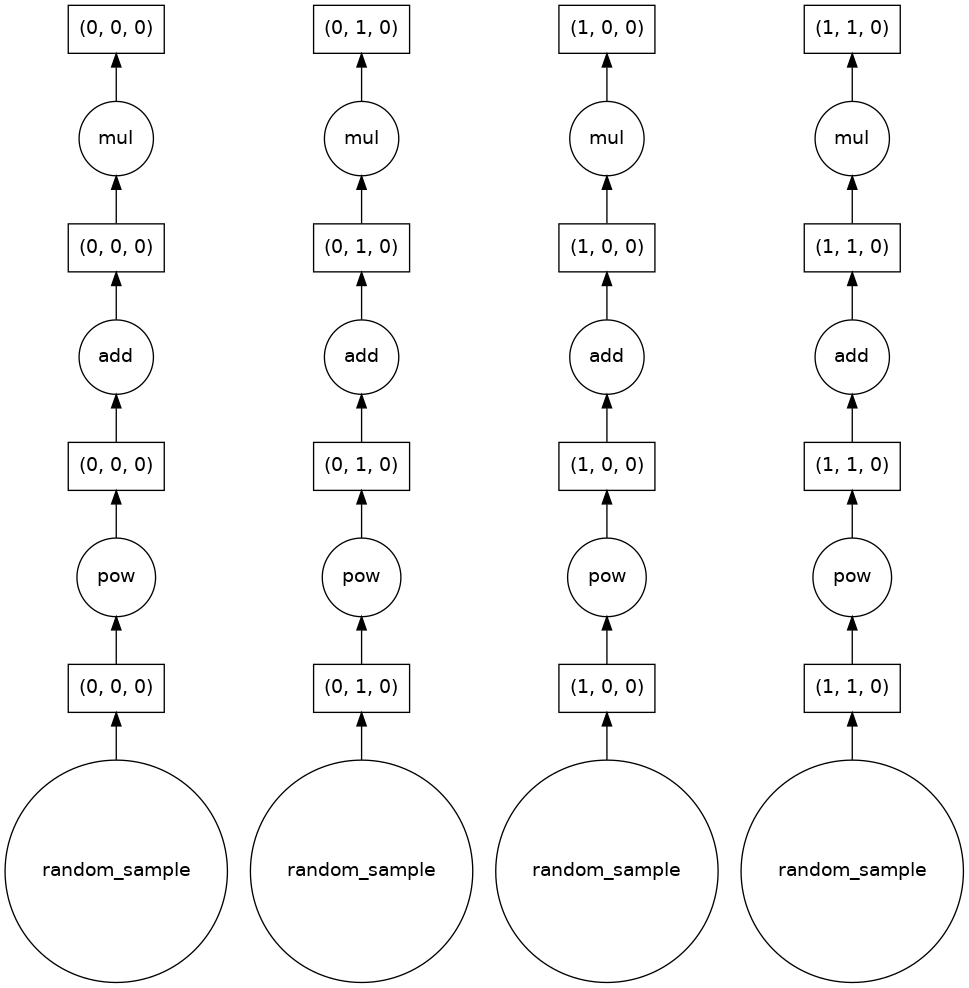

In [12]:
y.visualize()

In [13]:
#%%time
#TKE_usingcomputebyblocks = ccd.compute_by_block(TKE)

In [14]:
#fig = plt.figure(figsize=(5, 3.5), dpi=100)

#ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

#TKE_usingcomputebyblocks.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=20)

#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#ax.add_feature(land_50m, zorder=2)
#ax.outline_patch.set_linewidth(0.5)
#ax.set_title("TKE using cc's compute_by_block");

Snapshot plot of depth-integrated KE for 1970-12-01. As shown here, the conventional method of computing directly from the dataset only works in small slices of data (i.e., snapshots up to a couple of weeks for the 0.1 degree output).

In [15]:
#fig = plt.figure(figsize=(5, 3.5), dpi=100)

#ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

#KE_dz.isel(time=0).sum('st_ocean').plot(vmax=20, transform=ccrs.PlateCarree());

#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#ax.add_feature(land_50m, zorder=2)
#ax.outline_patch.set_linewidth(0.5)

## Mean Kinetic Energy

For the mean kinetic energy, we need to average the velocities over time.

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right). $$

In [16]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [17]:
MKE = (0.5*(u_mean**2 + v_mean**2)*dz).sum('st_ocean')

In [42]:
#%%time
#MKE = ccd.compute_by_block(MKE)

In [43]:
#fig = plt.figure(figsize=(5, 3.5), dpi=100)

#ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

#MKE.plot(ax=ax,transform=ccrs.PlateCarree(), vmax=5);

#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#ax.add_feature(land_50m, zorder=2)
#ax.outline_patch.set_linewidth(0.5)
#ax.set_title("MKE using cc's compute_by_block");

## Eddy Kinetic Energy

We calculate the transient component of the velocity field and then compute the EKE:


$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] }. $$

In [18]:
u_transient = u - u_mean
v_transient = v - v_mean

In [19]:
EKE = (0.5*(u_transient**2 + v_transient**2)*dz).sum('st_ocean').mean('time')

In [20]:
%%time
EKE = ccd.compute_by_block(EKE)

  0%|          | 0/1 [00:00<?, ?it/s]

2022-11-25 15:48:55,884 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-25 15:48:58,245 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-25 15:49:00,844 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-25 15:49:02,925 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36981
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/comm/tcp.py", line 229, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    retur

ValueError: Assignment destination is a view.  Do you want to .copy() array first?

In [21]:
EKE

<xarray.DataArray (yu_ocean: 93, xu_ocean: 160)>
dask.array<mean_agg-aggregate, shape=(93, 160), dtype=float64, chunksize=(93, 160), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -256.0 -255.9 -255.8 ... -240.3 -240.2 -240.1
  * yu_ocean  (yu_ocean) float64 -66.98 -66.94 -66.9 ... -63.11 -63.07 -63.02

2022-11-25 16:22:26,535 - distributed.scheduler - ERROR - 
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/scheduler.py", line 4047, in update_graph
    plugin.update_graph(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 38, in update_graph
    self.socket.send("update_graph", {"client": client})
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 199, in send
    self.write_message(data)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/tornado/websocket.py", line 337, in write_message
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2022-11-25 16:30:31,711 - distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/g

KeyboardInterrupt: 

2022-11-25 16:30:32,715 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-25 16:30:32,721 - distributed.nanny - ERROR - Worker process died unexpectedly


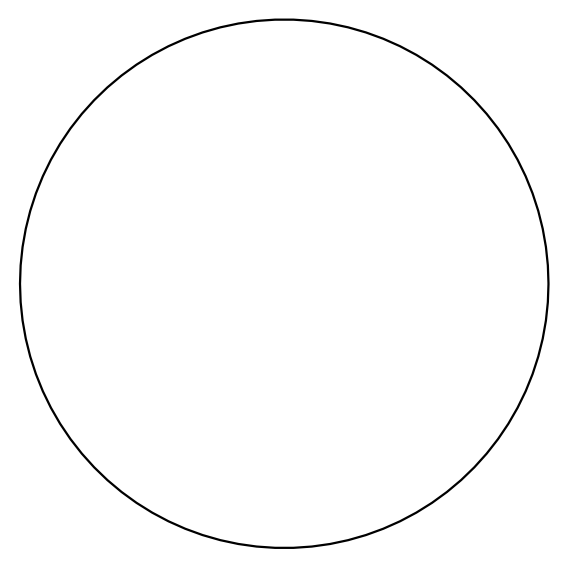

2022-11-25 16:30:37,956 - distributed.nanny - ERROR - Timeout
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/nanny.py", line 904, in _run
    loop.run_sync(run)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    handle._run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/asyncio/events.py", line 80, in _run
    self._

In [22]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection= ccrs.SouthPolarStereo())

EKE.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("EKE using cc's compute_by_block");

# Functions using the CC framework and dask.
(Functions of previously described code)

In [25]:
from joblib import Memory

memory = Memory(location='/g/data/v45/cosima-cookbook/', verbose=0)

In [26]:
from cosima_cookbook.netcdf_index import get_nc_variable

Here are functions for calculating both MKE and EKE using `cosima-cookbook`.

In [27]:
@memory.cache
def calc_mke(expt, start_time='1970-12-01'):
    
    print('Opening datasets...')
    u = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time=start_time)
    u = u.sel(time=slice('1970-12-01', '1970-12-31'))
    v = cc.querying.getvar(expt, 'v', session, ncfile='ocean_daily_3d_v_%.nc', start_time=start_time)
    v = v.sel(time=slice('1970-12-01', '1970-12-31'))
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    dz = np.gradient(KE.st_ocean)[:, np.newaxis, np.newaxis]
    MKE_cc = (0.5*(u_mean**2 + v_mean**2)*dz).sum('st_ocean')
    
    print('Calculating...')
    MKE_result = ccd.compute_by_block(MKE_cc)
    
    return MKE_result

In [28]:
%%time
MKE_cc = calc_mke(expt, start_time=start_time)

Opening datasets...


/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_11.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_11.nc', 'ocean_daily_3d_v_12.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "


Preparing computation...
Calculating...


CPU times: user 57.6 s, sys: 2.45 s, total: 1min
Wall time: 1min 20s


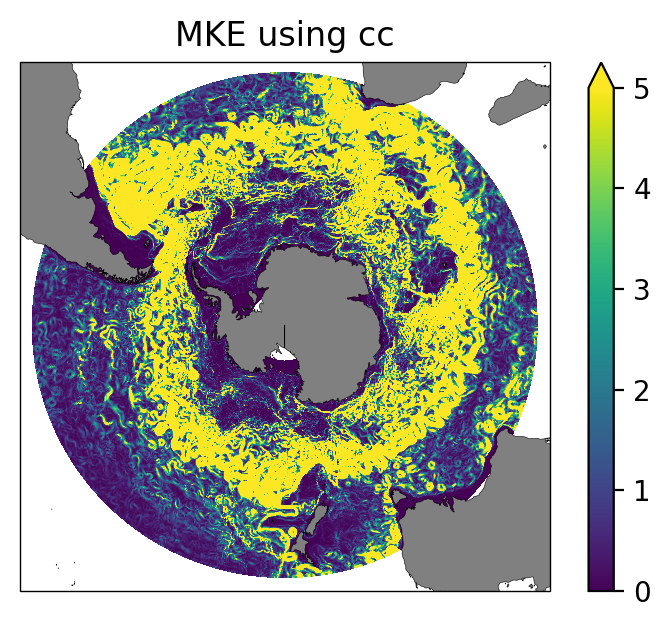

In [29]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

MKE_cc.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=5)

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("MKE using cc");

In [30]:
@memory.cache
def calc_eke(expt, start_time='1970-12-01'):
    
    print('Opening datasets...')
    u = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time=start_time)
    u = u.sel(time=slice('1970-12-01', '1970-12-31'))
    v = cc.querying.getvar(expt, 'v', session, ncfile='ocean_daily_3d_v_%.nc', start_time=start_time)
    v = v.sel(time=slice('1970-12-01', '1970-12-31'))
    
    print('Preparing computation...')
    u_mean = u.mean('time')
    v_mean = v.mean('time')
    
    dz = np.gradient(KE.st_ocean)[:, np.newaxis, np.newaxis]
    
    u_transient = u - u_mean
    v_transient = v - v_mean
    EKE_cc = (0.5*(u_transient**2 + v_transient**2)*dz).mean('time').sum('st_ocean')

    print('Calculating...')
    EKE_result = ccd.compute_by_block(EKE_cc)
    
    return EKE_result

In [31]:
%%time
EKE_cc = calc_eke(expt, start_time=start_time)

Opening datasets...


/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_12.nc', 'ocean_daily_3d_u_11.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_11.nc', 'ocean_daily_3d_v_12.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "


Preparing computation...
Calculating...


CPU times: user 1min 17s, sys: 4.33 s, total: 1min 21s
Wall time: 1min 47s


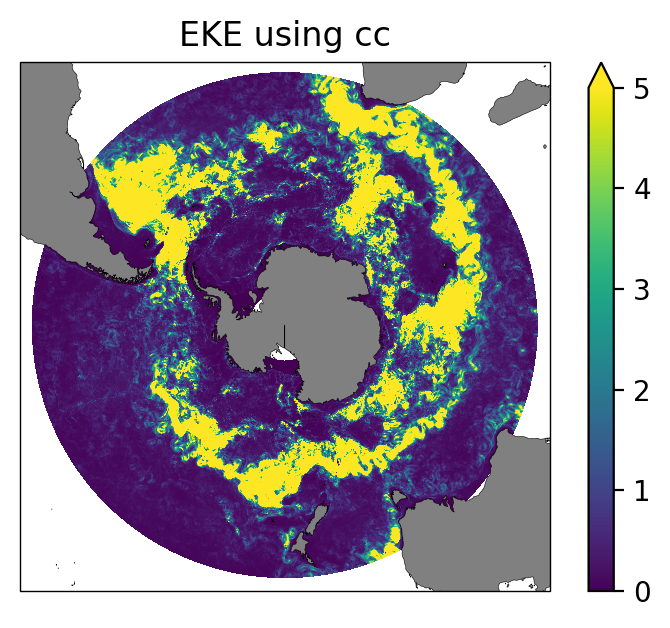

In [32]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

EKE_cc.plot(ax=ax,transform=ccrs.PlateCarree(), vmax=5)

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("EKE using cc");

## Implementation of `dask` directly

Note: This example below works but its performance could be improved (it requires further debugging).

In [33]:
import netCDF4
import dask.array as da

In [34]:
@memory.cache
def calc_mke_dask(expt):

    #Identify files and paths for u and v.
    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'u', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    u_ncfiles=ncfiles[-1:] # this picks up only the last month of output, Dec 1970
    
    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'v', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    v_ncfiles=ncfiles[-1:] # this picks up only the last month of output, Dec 1970

    #Construct datasets
    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1, 7, 300, 400)) for ncfile in u_ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1, 7, 300, 400)) for ncfile in v_ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)

    #Make sure to mask fillvalue.
    u[u==netCDF4.Dataset(u_ncfiles[0], 'r')['u'].getncattr('_FillValue')]=np.nan
    v[v==netCDF4.Dataset(v_ncfiles[0], 'r')['v'].getncattr('_FillValue')]=np.nan
    
    #Compute averages with nan.
    u_mean = da.nanmean(u, axis=0)
    v_mean = da.nanmean(v, axis=0)
    
    # Create temporal xarray structure
    temp = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time=start_time).isel(time=-1)
    
    # Define dz for intergral on depth.
    dz = np.gradient(temp.st_ocean)[:, np.newaxis, np.newaxis]
    
    #Compute MKE
    MKEdensity = 0.5 * (u_mean**2 + v_mean**2)
    MKE_int = da.nansum(MKEdensity*dz, axis=0)
    
    MKE = ccd.compute_by_block(MKE_int)
    
    #Store files
    template = temp.sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = MKE
    result.name = 'MKE'
    
    return result

In [35]:
%%time
MKE_v2 = calc_mke_dask(expt)

CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 17.1 ms


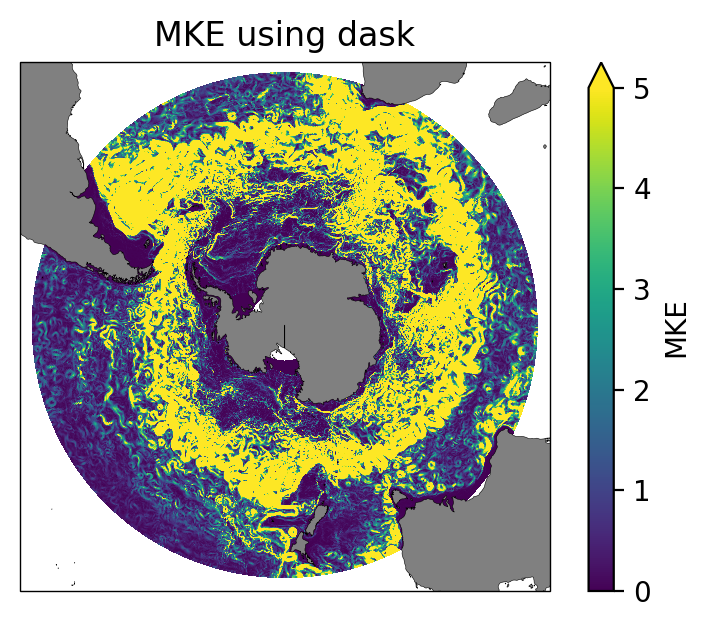

In [36]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection= ccrs.SouthPolarStereo())

MKE_v2.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("MKE using dask");

In [37]:
@memory.cache
def calc_eke_dask(expt):

    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'u', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    u_ncfiles=ncfiles[-1:] # this picks up only the last month of output, Dec 1970
    
    ncfiles=[str(f[0].ncfile_path)  for f in cc.querying._ncfiles_for_variable(expt, 'v', session) if 'ocean_daily_3d' in str(f[0].ncfile_path) ]
    v_ncfiles=ncfiles[-1:] # this picks up only the last month of output, Dec 1970

    u_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['u'],
            chunks=(1, 7, 300, 400)) for ncfile in u_ncfiles]
    u = da.concatenate(u_dataarrays, axis=0)

    v_dataarrays = [da.from_array(netCDF4.Dataset(ncfile, 'r')['v'],
            chunks=(1, 7, 300, 400)) for ncfile in v_ncfiles]
    v = da.concatenate(v_dataarrays, axis=0)
    
    u[u==netCDF4.Dataset(u_ncfiles[0], 'r')['u'].getncattr('_FillValue')]=np.nan
    v[v==netCDF4.Dataset(v_ncfiles[0], 'r')['v'].getncattr('_FillValue')]=np.nan

    u_mean = da.nanmean(u,axis=0)
    v_mean = da.nanmean(v,axis=0)
    
    # Create temporal xarray structure
    temp = cc.querying.getvar(expt, 'u', session, ncfile='ocean_daily_3d_u_%.nc', start_time = start_time).isel(time=-1)
    
    # Define dz for intergral on depth.
    dz = np.gradient(temp.st_ocean)[:, np.newaxis, np.newaxis]
    
    u_transient = u - u_mean
    v_transient = v - v_mean

    EKEdensity = 0.5 * (u_transient**2 + v_transient**2)
    EKEmeantime = da.nanmean(EKEdensity, axis=0)
    EKEsum = da.nansum(EKEmeantime*dz, axis=0)
    
    EKE_dask = ccd.compute_by_block(EKEsum)
    
    template = temp.sum('st_ocean')
    result = xr.zeros_like(template).compute()
    result[:] = EKE_dask
    result.name = 'EKE'
    
    return result

In [38]:
%%time
EKE_v2 = calc_eke_dask(expt)

/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_u_04.nc', 'ocean_daily_3d_u_01.nc', 'ocean_daily_3d_u_12.nc', 'ocean.nc', 'ocean_daily_3d_u_10.nc', 'ocean_daily_3d_u_07.nc', 'ocean_daily_3d_u_09.nc', 'ocean_daily_3d_u_08.nc', 'ocean_daily_3d_u_03.nc', 'ocean_daily_3d_u_05.nc', 'ocean_daily_3d_u_11.nc', 'ocean_daily_3d_u_02.nc', 'ocean_daily_3d_u_06.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "
/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_daily_3d_v_08.nc', 'ocean_daily_3d_v_10.nc', 'ocean_daily_3d_v_12.nc', 'ocean_daily_3d_v_02.nc', 'ocean_daily_3d_v_11.nc', 'ocean.nc', 'ocean_daily_3d_v_07.nc', 'oc

CPU times: user 1min 13s, sys: 4.2 s, total: 1min 17s
Wall time: 1min 39s


NameError: name 'EKE_v2' is not defined

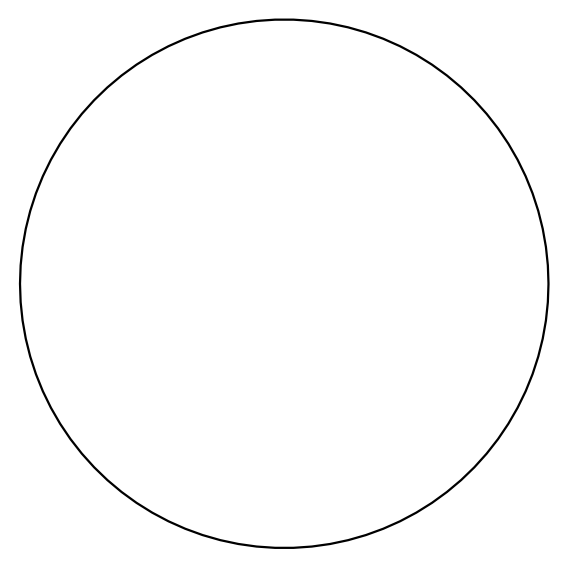

2022-11-25 14:56:30,950 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:30,954 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:30,957 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:31,357 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:31,518 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:31,726 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:31,737 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:32,460 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:32,464 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:32,467 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:32,599 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:32,902 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:32,910 - distributed.nanny - WARNING - Restarting worker
2022-11-25 14:56:33,077 - distributed.

In [47]:
fig = plt.figure(figsize=(5, 3.5), dpi=100)

ax = fig.add_subplot(1, 1, 1, projection= ccrs.SouthPolarStereo())

EKE_v2.plot(ax=ax,transform=ccrs.PlateCarree(), vmax=5);

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("EKE using dask");

We can confirm that the two methods give the same result.

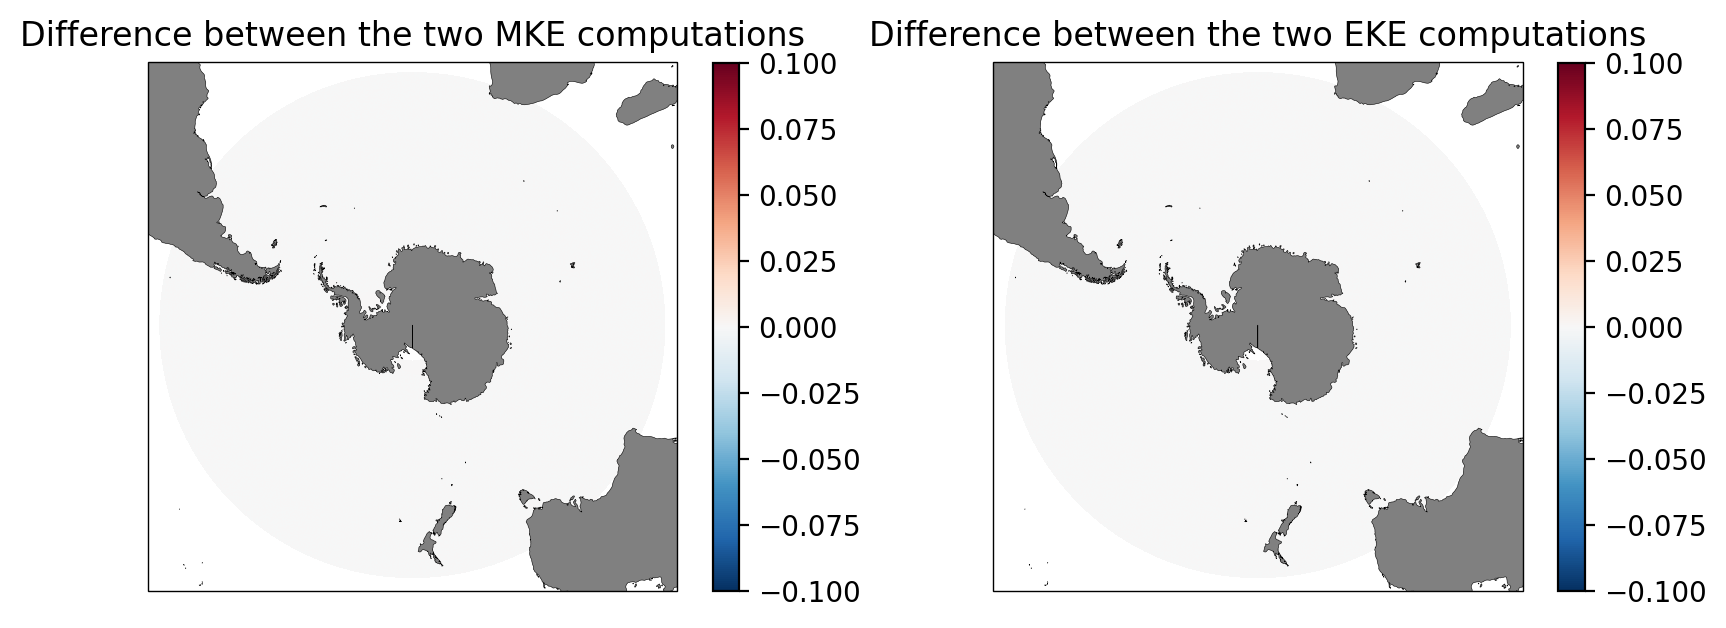

In [40]:
fig = plt.figure(figsize=(10, 3.5), dpi=100)

ax = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

(MKE-MKE_v2).plot(ax=ax, transform=ccrs.PlateCarree(), vmax=0.1)

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("Difference between the two MKE computations")

ax = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

(EKE-EKE_v2).plot(ax=ax, transform=ccrs.PlateCarree(), vmax=0.1)

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(land_50m, zorder=2)
ax.outline_patch.set_linewidth(0.5)
ax.set_title("Difference between the two EKE computations");

## Remarks on walltime and reliability of the two methods

Note the walltime of the `CC` implementation was  1min 20s for MKE and 1min 47s for EKE to analyze 31 days of data.

Meanwhile, the `dask`-`netCDF4` implementation used 17.1 ms for MKE and 1min 39s for EKE for the same dataset.

Both results are comparable, perhaps slightly faster with the `dask`-`netCDF4` implementation. Note, however, that the `dask`-`netCDF4` implementation is more reliable when handling larger datasets (i.e., daily climatology from multi-year output datasets).